In [11]:
import numpy as np
from sklearn.mixture import GaussianMixture
import librosa
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [12]:
def getMfcc(wav):
    wav = librosa.util.fix_length(wav, size=16000)
    wav = librosa.effects.preemphasis(y=wav, coef=0.97)

    mfcc = librosa.feature.mfcc(y=wav,
                                sr=16000,
                                n_fft=400,
                                hop_length=160,
                                n_mfcc=100
                                )
    
    mfcc = mfcc[1:]
    
    scaler = MinMaxScaler()
    mfcc = scaler.fit_transform(mfcc)

    
    return mfcc.T

In [13]:
def calculate_train_loss(male_gmm, female_gmm, feml, male):
    male_score = male_gmm.score_samples(male)  # score_samples()를 사용하여 각 샘플의 점수를 계산
    female_score = female_gmm.score_samples(feml)  # score_samples()를 사용하여 각 샘플의 점수를 계산

    train_loss = 0.0

    # 예측 결과를 바탕으로 loss 계산 (여기서는 간단히 차이의 제곱을 사용)
    for i in range(len(male_score)):
        if male_score[i] >= female_score[i]:
            train_loss += (male_score[i] - female_score[i]) ** 2
        else:
            train_loss += (female_score[i] - male_score[i]) ** 2

    train_loss /= len(male_score)

    return train_loss

In [14]:
train_data_file = "fmcc_train.ctl"

In [15]:
train_feml = []
train_male = []

# Train 데이터 남/여 구분
with open("data/" + train_data_file, 'r') as file:
    for file_path in file:
        file_path = file_path.rstrip("\n")
        wav, sr = librosa.load("data/wav16k/train/" + file_path + ".wav", sr=16000, mono=True)

        mfcc = getMfcc(wav)

        if file_path[0] == "F":
            train_feml.extend(mfcc)
        else:
            train_male.extend(mfcc)

feml = np.array(train_feml)
male = np.array(train_male)

np.save('female.npy', feml)
np.save('male.npy', male)

In [16]:
male_gmm = GaussianMixture(n_components=1, random_state=42)
female_gmm = GaussianMixture(n_components=1, random_state=42)

In [17]:
feml = np.load('female.npy')
male = np.load('male.npy')

In [18]:
male_gmm.fit(male)
female_gmm.fit(feml)

GaussianMixture(random_state=42)

In [19]:
rate = 0

with open("data/fmcc_test_ref.txt", 'r') as file:
    for file_path in file:
        file_path = file_path.rstrip("\n")

        file_path, gender = file_path.split()

        wav, frame_rate = librosa.load("data/wav16k/test/" + file_path + ".wav",
                                       sr=16000, mono=True)

        mfcc = getMfcc(wav)

        male_score = male_gmm.score(mfcc)
        female_score = female_gmm.score(mfcc)

        if gender == "male":
            if male_score >= female_score:
                rate += 1
        else:
            if male_score <= female_score:
                rate += 1

print(rate/9)
print(rate)

87.33333333333333
786


Epoch 1/10, Train Loss: 1588.70106602774
Epoch 2/10, Train Loss: 1588.70106602774
Epoch 3/10, Train Loss: 1588.70106602774
Epoch 4/10, Train Loss: 1588.70106602774
Epoch 5/10, Train Loss: 1588.70106602774
Epoch 6/10, Train Loss: 1588.70106602774
Epoch 7/10, Train Loss: 1588.70106602774
Epoch 8/10, Train Loss: 1588.70106602774
Epoch 9/10, Train Loss: 1588.70106602774
Epoch 10/10, Train Loss: 1588.70106602774


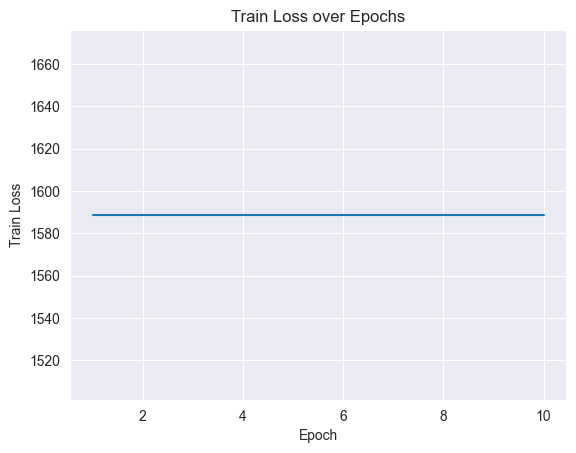

In [20]:
train_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    # 모델 학습 코드
    male_gmm.fit(male)
    female_gmm.fit(feml)

    # 매 에포크마다 train loss 계산
    train_loss = calculate_train_loss(male_gmm, female_gmm, feml, male)
    train_losses.append(train_loss)

    # 에포크 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}")

# Train loss 그래프 그리기
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.show()